In [1]:
!pip install -U scikit-learn==1.4.2
!pip install -U xgboost==1.7.6


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)
import xgboost as xgb

In [2]:
# === Load dataset ===
df = pd.read_csv("Full_genes.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("m6A rate:", df['label'].mean())

# === Features & labels ===
X = df.drop(columns=['gene_id','transcript_id','transcript_position','sequence','label'])
y = df['label']

# === Train/val/test split ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Dataset shape: (957600, 14)
Columns: ['gene_id', 'transcript_id', 'transcript_position', 'sequence', 'label', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
m6A rate: 0.03861111111111111
Train: (574560, 9) Val: (191520, 9) Test: (191520, 9)


In [3]:
# === Handle imbalance with undersampling (3:1 ratio) ===
train_df = X_train.copy()
train_df['label'] = y_train

majority = train_df[train_df['label'] == 0]
minority = train_df[train_df['label'] == 1]

majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority) * 3,  # 3:1 ratio
    random_state=42
)

train_bal = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=42)

X_train_bal = train_bal.drop(columns=['label'])
y_train_bal = train_bal['label']

print("Original training size:", X_train.shape)
print("After undersampling:", X_train_bal.shape)
print("Label distribution after balancing:")
print(y_train_bal.value_counts())

Original training size: (574560, 9)
After undersampling: (88736, 9)
Label distribution after balancing:
label
0    66552
1    22184
Name: count, dtype: int64


In [ ]:
# === Fine-tune XGBoost ===
xgb_model = xgb.XGBClassifier(
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [3] 
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("\n=== Starting grid search")
grid.fit(X_train_bal, y_train_bal)

print("\nBest parameters:", grid.best_params_)
print("Best mean ROC-AUC (CV):", grid.best_score_)

best_model = grid.best_estimator_


=== Starting grid search (this may take a while) ===
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': 3, 'subsample': 1.0}
Best mean ROC-AUC (CV): 0.8283515765073527


In [5]:
# === Evaluate on validation and test sets ===
for split_name, (X_eval, y_eval) in {
    "Validation": (X_val, y_val),
    "Test": (X_test, y_test)
}.items():
    y_pred = best_model.predict(X_eval)
    y_prob = best_model.predict_proba(X_eval)[:, 1]
    print(f"\n=== {split_name} Set Evaluation ===")
    print("Accuracy:", (y_pred == y_eval).mean())
    print("ROC-AUC:", roc_auc_score(y_eval, y_prob))
    print("PR-AUC:", average_precision_score(y_eval, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))
    print(classification_report(y_eval, y_pred, digits=4))


=== Validation Set Evaluation ===
Accuracy: 0.7463450292397661
ROC-AUC: 0.8330014094586029
PR-AUC: 0.22779669030574937
Confusion Matrix:
 [[137321  46804]
 [  1776   5619]]
              precision    recall  f1-score   support

           0     0.9872    0.7458    0.8497    184125
           1     0.1072    0.7598    0.1879      7395

    accuracy                         0.7463    191520
   macro avg     0.5472    0.7528    0.5188    191520
weighted avg     0.9533    0.7463    0.8241    191520


=== Test Set Evaluation ===
Accuracy: 0.7442303675856308
ROC-AUC: 0.8315793616629646
PR-AUC: 0.23062596513392647
Confusion Matrix:
 [[136977  47148]
 [  1837   5558]]
              precision    recall  f1-score   support

           0     0.9868    0.7439    0.8483    184125
           1     0.1055    0.7516    0.1850      7395

    accuracy                         0.7442    191520
   macro avg     0.5461    0.7478    0.5166    191520
weighted avg     0.9527    0.7442    0.8227    191520



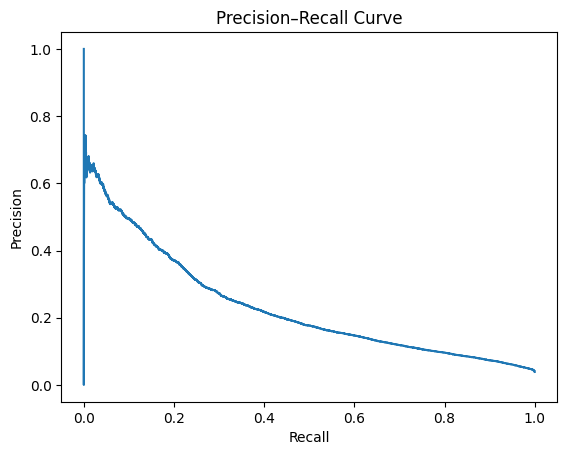

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p, r, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.plot(r, p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.show()


In [ ]:
import joblib
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# Save trained model and best parameter
joblib.dump(best_model, "xgb_best_model.pkl")

with open("xgb_best_params.json", "w") as f:
    json.dump(grid.best_params_, f, indent=4)


In [ ]:
import numpy as np

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

results = {
    "Accuracy": float((y_pred == y_test).mean()),
    "ROC_AUC": float(roc_auc_score(y_test, y_prob)),
    "PR_AUC": float(average_precision_score(y_test, y_prob)),
    "Confusion_Matrix": confusion_matrix(y_test, y_pred).tolist(),
    "Classification_Report": classification_report(y_test, y_pred, output_dict=True)
}

with open("xgb_eval_results.json", "w") as f:
    json.dump(results, f, indent=4)


In [10]:
from google.colab import files

files.download("xgb_best_model.pkl")
files.download("xgb_best_params.json")
files.download("xgb_eval_results.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>